Training Q-learning policy...
Episode   500 | avg_reward= -51.30 | avg_served=34.53 | avg_abandoned=31.17
Episode  1000 | avg_reward=  12.36 | avg_served=38.44 | avg_abandoned=27.90
Episode  1500 | avg_reward=  59.72 | avg_served=42.08 | avg_abandoned=24.21
Episode  2000 | avg_reward= 102.60 | avg_served=45.08 | avg_abandoned=21.31
Episode  2500 | avg_reward= 140.81 | avg_served=47.36 | avg_abandoned=18.69
Episode  3000 | avg_reward= 176.20 | avg_served=50.33 | avg_abandoned=15.97
Episode  3500 | avg_reward= 202.89 | avg_served=52.61 | avg_abandoned=13.95
Episode  4000 | avg_reward= 235.25 | avg_served=55.28 | avg_abandoned=11.54
Episode  4500 | avg_reward= 256.98 | avg_served=57.24 | avg_abandoned= 9.74
Episode  5000 | avg_reward= 259.43 | avg_served=57.36 | avg_abandoned= 9.26

Evaluating learned policy...
t=1 | Queue=0 | Free=5 | SeatedWaitingFood=0 | Ready=0 | Dirty=0 | Served=0 | Abandoned=0
t=2 | Queue=0 | Free=5 | SeatedWaitingFood=0 | Ready=0 | Dirty=0 | Served=0 | Abandoned=0


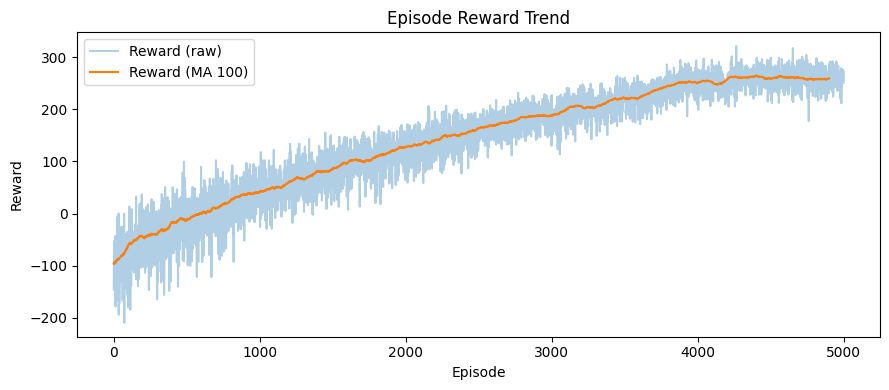

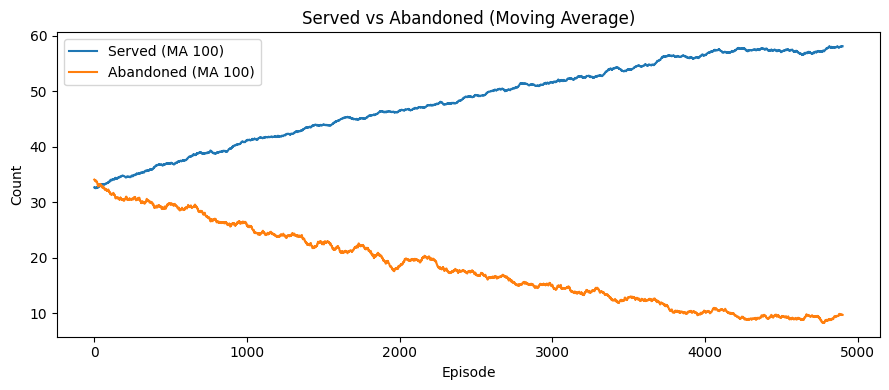

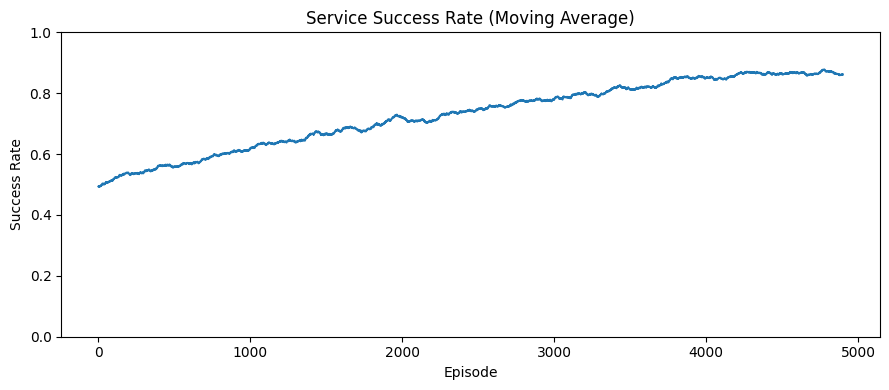

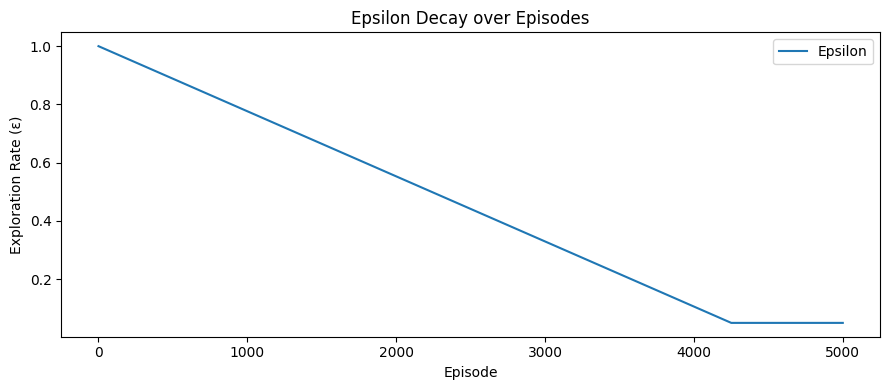

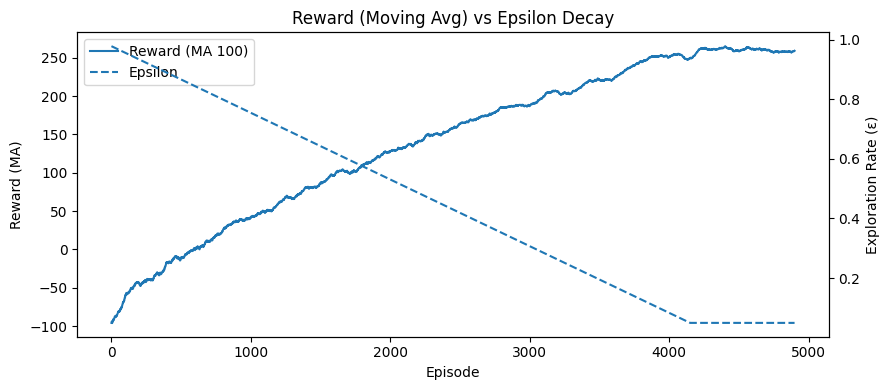

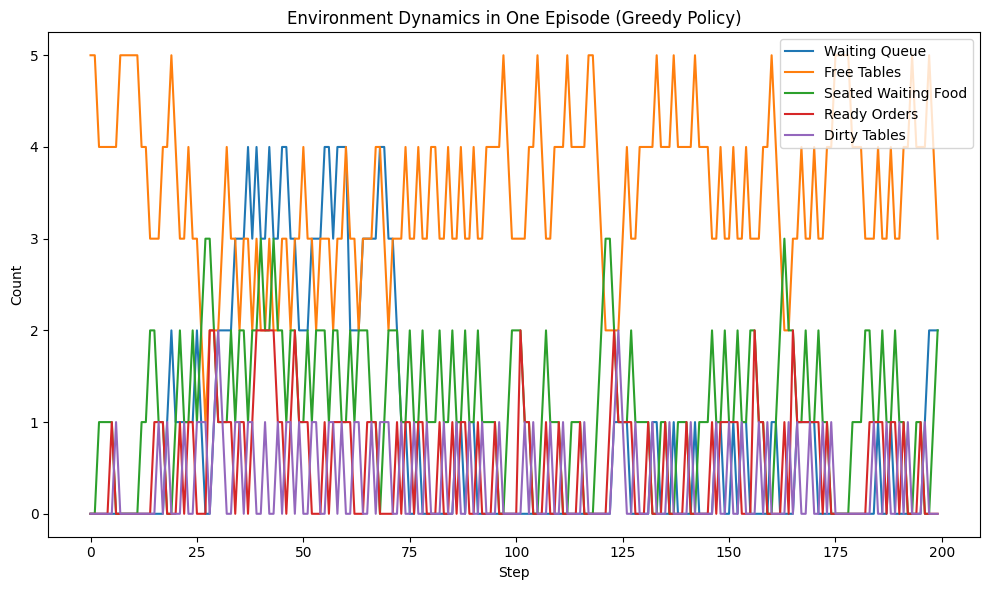

In [ ]:
# ==============================
# Restaurant Waiter Simulator RL
# Custom Gymnasium Env + Q-Learning + Plots (+ Epsilon Tracking & Combined Plot)
# ==============================

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# ------------------------------
# 1) Custom Environment (No Grid)
# ------------------------------
class RestaurantWaiterEnv(gym.Env):
    """
    A non-grid, event-driven restaurant simulator.

    State = (waiting_queue, free_tables, seated_waiting_food, ready_orders, dirty_tables)
    Actions:
      0: Idle
      1: Seat & Take Order     (if waiting_queue > 0 and free_tables > 0)
      2: Serve Ready Order     (if ready_orders > 0)
      3: Clean Table           (if dirty_tables > 0)
    """
    metadata = {"render_modes": ["ansi"]}

    def __init__(
        self,
        max_tables=5,
        max_queue=10,
        max_kitchen_backlog=10,
        episode_len=200,
        p_arrival=0.35,
        cook_time_min=2,
        cook_time_max=5,
        patience_min=6,
        patience_max=12,
        seed=None,
        render_mode=None
    ):
        super().__init__()
        self.rng = np.random.default_rng(seed)

        # Parameters
        self.max_tables = max_tables
        self.max_queue = max_queue
        self.max_kitchen_backlog = max_kitchen_backlog
        self.episode_len = episode_len
        self.p_arrival = p_arrival
        self.cook_time_min = cook_time_min
        self.cook_time_max = cook_time_max
        self.patience_min = patience_min
        self.patience_max = patience_max

        # Observation space (discrete counts)
        low  = np.array([0, 0, 0, 0, 0], dtype=np.int32)
        high = np.array([self.max_queue, self.max_tables, self.max_tables,
                         self.max_tables, self.max_tables], dtype=np.int32)
        self.observation_space = spaces.Box(low=low, high=high, shape=(5,), dtype=np.int32)

        # Actions
        self.action_space = spaces.Discrete(4)

        # Internal trackers
        self.waiting_patience = deque()  # patience list for each customer in queue
        self.kitchen_orders = deque()    # remaining cook times for each active order

        self.free_tables = self.max_tables
        self.seated_waiting_food = 0
        self.ready_orders = 0
        self.dirty_tables = 0
        self.waiting_queue = 0

        self.t = 0
        self.total_served = 0
        self.total_abandoned = 0

        self.render_mode = render_mode
        self._last_info = {}

    def seed(self, seed=None):
        self.rng = np.random.default_rng(seed)

    def _bounded_inc(self, val, maxv, inc=1): return min(val + inc, maxv)
    def _bounded_dec(self, val, dec=1): return max(val - dec, 0)

    def _state(self):
        return np.array([
            self.waiting_queue,
            self.free_tables,
            self.seated_waiting_food,
            self.ready_orders,
            self.dirty_tables
        ], dtype=np.int32)

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.seed(seed)
        self.waiting_patience.clear()
        self.kitchen_orders.clear()
        self.free_tables = self.max_tables
        self.seated_waiting_food = 0
        self.ready_orders = 0
        self.dirty_tables = 0
        self.waiting_queue = 0
        self.t = 0
        self.total_served = 0
        self.total_abandoned = 0
        return self._state(), {}

    def step(self, action):
        """
        Order:
        1) Arrivals
        2) Apply action
        3) Kitchen progresses -> ready orders
        4) Patience decay & abandon
        5) Rewards & termination
        """
        reward = 0.0
        info = {}
        done = False
        truncated = False

        # (1) Arrivals
        if self.rng.random() < self.p_arrival and self.waiting_queue < self.max_queue:
            self.waiting_queue += 1
            pat = int(self.rng.integers(self.patience_min, self.patience_max + 1))
            self.waiting_patience.append(pat)

        # (2) Apply action
        if action == 1:
            if self.waiting_queue > 0 and self.free_tables > 0:
                self.waiting_queue -= 1
                self.free_tables -= 1
                self.seated_waiting_food += 1
                if self.waiting_patience:
                    self.waiting_patience.popleft()
                if len(self.kitchen_orders) < self.max_kitchen_backlog:
                    cook_time = int(self.rng.integers(self.cook_time_min, self.cook_time_max + 1))
                    self.kitchen_orders.append(cook_time)
                    reward += 1.0
        elif action == 2:
            if self.ready_orders > 0:
                self.ready_orders -= 1
                self.seated_waiting_food = self._bounded_dec(self.seated_waiting_food, 1)
                self.dirty_tables = self._bounded_inc(self.dirty_tables, self.max_tables, 1)
                reward += 5.0
                self.total_served += 1
        elif action == 3:
            if self.dirty_tables > 0:
                self.dirty_tables -= 1
                self.free_tables = self._bounded_inc(self.free_tables, self.max_tables, 1)
                reward += 1.0
        # action == 0 -> idle

        # (3) Kitchen progress
        finished = 0
        if self.kitchen_orders:
            for i in range(len(self.kitchen_orders)):
                self.kitchen_orders[i] -= 1
            while self.kitchen_orders and self.kitchen_orders[0] <= 0:
                self.kitchen_orders.popleft()
                finished += 1
        if finished > 0:
            can_ready = min(finished, self.seated_waiting_food - self.ready_orders)
            if can_ready > 0:
                self.ready_orders = min(self.ready_orders + can_ready, self.max_tables)

        # (4) Patience decay & abandon
        abandons = 0
        if self.waiting_queue > 0 and self.waiting_patience:
            self.waiting_patience = deque([p - 1 for p in self.waiting_patience])
            while self.waiting_patience and self.waiting_patience[0] <= 0 and self.waiting_queue > 0:
                self.waiting_patience.popleft()
                self.waiting_queue -= 1
                abandons += 1
            if abandons > 0:
                self.total_abandoned += abandons
                reward -= 2.0 * abandons

        # (5) Shaping penalties
        reward -= 0.1 * self.waiting_queue
        reward -= 0.2 * self.seated_waiting_food
        reward -= 0.5 * self.dirty_tables
        reward -= 0.01

        self.t += 1
        if self.t >= self.episode_len:
            done = True

        info.update({
            "served": self.total_served,
            "abandoned": self.total_abandoned,
            "finished_now": finished,
            "abandons_now": abandons
        })
        self._last_info = info
        return self._state(), float(reward), done, truncated, info

    def render(self):
        s = (
            f"t={self.t} | "
            f"Queue={self.waiting_queue} | Free={self.free_tables} | "
            f"SeatedWaitingFood={self.seated_waiting_food} | Ready={self.ready_orders} | "
            f"Dirty={self.dirty_tables} | Served={self.total_served} | "
            f"Abandoned={self.total_abandoned}"
        )
        return s

# -----------------------------------
# 2) Q-Learning over the discrete env
# -----------------------------------
def encode_state(state, env):
    W = env.max_queue + 1
    F = env.max_tables + 1
    S = env.max_tables + 1
    R = env.max_tables + 1
    D = env.max_tables + 1
    w, f, s, r, d = state.astype(int)
    idx = (((w * F + f) * S + s) * R + r) * D + d
    return idx

def make_q_table(env):
    W = env.max_queue + 1
    F = env.max_tables + 1
    S = env.max_tables + 1
    R = env.max_tables + 1
    D = env.max_tables + 1
    n_states = W * F * S * R * D
    n_actions = env.action_space.n
    return np.zeros((n_states, n_actions), dtype=np.float32)

def epsilon_greedy(q_row, epsilon):
    if random.random() < epsilon:
        return random.randrange(len(q_row))
    return int(np.argmax(q_row))

def train_q_learning(
    env,
    episodes=5000,
    alpha=0.15,
    gamma=0.98,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay_ratio=0.85,
    verbose_every=500
):
    q = make_q_table(env)
    # Track epsilon each episode (recorded during learning)
    metrics = {"ep_reward": [], "ep_served": [], "ep_abandoned": [], "epsilon": []}

    decay_episodes = int(episodes * epsilon_decay_ratio)
    def get_epsilon(ep):
        if ep < decay_episodes:
            return epsilon_start - (epsilon_start - epsilon_end) * (ep / decay_episodes)
        return epsilon_end

    for ep in range(1, episodes + 1):
        state, _ = env.reset()
        s_idx = encode_state(state, env)
        done = False
        total_r = 0.0
        served0 = 0
        abandoned0 = 0
        epsilon = get_epsilon(ep)  # <-- computed per-episode

        while not done:
            action = epsilon_greedy(q[s_idx], epsilon)
            next_state, reward, done, truncated, info = env.step(action)
            ns_idx = encode_state(next_state, env)

            best_next = np.max(q[ns_idx])
            q[s_idx, action] += alpha * (reward - q[s_idx, action] + gamma * best_next)

            s_idx = ns_idx
            total_r += reward
            served0 = info.get("served", served0)
            abandoned0 = info.get("abandoned", abandoned0)

        # Record metrics including the epsilon used during this episode
        metrics["ep_reward"].append(total_r)
        metrics["ep_served"].append(served0)
        metrics["ep_abandoned"].append(abandoned0)
        metrics["epsilon"].append(epsilon)

        if verbose_every and (ep % verbose_every == 0):
            avgR = np.mean(metrics["ep_reward"][-verbose_every:])
            avgS = np.mean(metrics["ep_served"][-verbose_every:])
            avgA = np.mean(metrics["ep_abandoned"][-verbose_every:])
            print(f"Episode {ep:5d} | avg_reward={avgR:7.2f} | avg_served={avgS:5.2f} | avg_abandoned={avgA:5.2f}")

    return q, metrics

# ------------------------
# 3) Evaluation Utilities
# ------------------------
def evaluate_policy(env, q, episodes=20, render=False):
    total_r = 0.0
    total_served = 0
    total_abandoned = 0
    for ep in range(episodes):
        s, _ = env.reset()
        done = False
        ep_r = 0.0
        served0 = 0
        abandoned0 = 0
        while not done:
            s_idx = encode_state(s, env)
            a = int(np.argmax(q[s_idx]))
            s, r, done, truncated, info = env.step(a)
            ep_r += r
            if render and (ep == episodes - 1):
                print(env.render())
            served0 = info.get("served", served0)
            abandoned0 = info.get("abandoned", abandoned0)
        total_r += ep_r
        total_served += served0
        total_abandoned += abandoned0
    print(f"[EVAL] episodes={episodes} | avg_reward={total_r / episodes:.2f} | "
          f"avg_served={total_served / episodes:.2f} | avg_abandoned={total_abandoned / episodes:.2f}")

# ------------------------
# 4) Visualization Helpers
# ------------------------
def moving_avg(x, w):
    x = np.asarray(x, dtype=float)
    if w <= 1 or w > len(x):
        return x
    return np.convolve(x, np.ones(w)/w, mode='valid')

def plot_training(history, window=100):
    """Plot reward trend, served vs abandoned, success rate, epsilon decay, and a combined overlay."""
    rewards = history["ep_reward"]
    served = history["ep_served"]
    abandoned = history["ep_abandoned"]
    eps_vals = history.get("epsilon", None)

    # Figure 1: Reward (raw + moving average)
    plt.figure(figsize=(9,4))
    plt.plot(rewards, alpha=0.35, label="Reward (raw)")
    ma_r = moving_avg(rewards, window)
    plt.plot(np.arange(len(ma_r)), ma_r, label=f"Reward (MA {window})")
    plt.title("Episode Reward Trend")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Figure 2: Served vs Abandoned (moving averages)
    plt.figure(figsize=(9,4))
    ma_s = moving_avg(served, window)
    ma_a = moving_avg(abandoned, window)
    plt.plot(np.arange(len(ma_s)), ma_s, label=f"Served (MA {window})")
    plt.plot(np.arange(len(ma_a)), ma_a, label=f"Abandoned (MA {window})")
    plt.title("Served vs Abandoned (Moving Average)")
    plt.xlabel("Episode")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Figure 3: Success rate = served / (served + abandoned)
    eps = 1e-9
    sr = np.array(served) / (np.array(served) + np.array(abandoned) + eps)
    ma_sr = moving_avg(sr, window)
    plt.figure(figsize=(9,4))
    plt.plot(np.arange(len(ma_sr)), ma_sr)
    plt.title("Service Success Rate (Moving Average)")
    plt.xlabel("Episode")
    plt.ylabel("Success Rate")
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

    # Figure 4: Epsilon decay over episodes
    if eps_vals is not None:
        plt.figure(figsize=(9,4))
        plt.plot(eps_vals, label="Epsilon")
        plt.title("Epsilon Decay over Episodes")
        plt.xlabel("Episode")
        plt.ylabel("Exploration Rate (ε)")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Figure 5: Combined overlay — Reward (MA) vs Epsilon on twin axes
        if len(ma_r) > 0:
            fig, ax1 = plt.subplots(figsize=(9,4))
            ax1.plot(np.arange(len(ma_r)), ma_r, label=f"Reward (MA {window})")
            ax1.set_xlabel("Episode")
            ax1.set_ylabel("Reward (MA)")
            ax1.set_title("Reward (Moving Avg) vs Epsilon Decay")

            ax2 = ax1.twinx()
            # Align lengths if needed by trimming epsilon to MA length
            eps_trim = eps_vals[-len(ma_r):] if len(eps_vals) >= len(ma_r) else eps_vals
            x_eps = np.arange(len(eps_trim))
            ax2.plot(x_eps, eps_trim, label="Epsilon", linestyle="--")
            ax2.set_ylabel("Exploration Rate (ε)")

            # Build a combined legend
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
            fig.tight_layout()
            plt.show()

def visualize_episode(env, q):
    """Plot state dynamics across one greedy-policy episode."""
    traj = []
    s, _ = env.reset()
    done = False
    while not done:
        s_idx = encode_state(s, env)
        a = int(np.argmax(q[s_idx]))
        s, r, done, truncated, info = env.step(a)
        traj.append(env._state())
    traj = np.array(traj)

    plt.figure(figsize=(10,6))
    plt.plot(traj[:,0], label="Waiting Queue")
    plt.plot(traj[:,1], label="Free Tables")
    plt.plot(traj[:,2], label="Seated Waiting Food")
    plt.plot(traj[:,3], label="Ready Orders")
    plt.plot(traj[:,4], label="Dirty Tables")
    plt.title("Environment Dynamics in One Episode (Greedy Policy)")
    plt.xlabel("Step")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------------
# 5) Main (Train + Eval + Plots)
# ------------------------
if __name__ == "__main__":
    env = RestaurantWaiterEnv(
        max_tables=5,
        max_queue=10,
        max_kitchen_backlog=10,
        episode_len=200,
        p_arrival=0.35,
        cook_time_min=2,
        cook_time_max=5,
        patience_min=6,
        patience_max=12,
        seed=42
    )

    print("Training Q-learning policy...")
    q, history = train_q_learning(
        env,
        episodes=5000,
        alpha=0.15,
        gamma=0.98,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay_ratio=0.85,
        verbose_every=500
    )

    print("\nEvaluating learned policy...")
    evaluate_policy(env, q, episodes=20, render=True)

    # ---- Plots ----
    plot_training(history, window=100)
    visualize_episode(env, q)
